In [ ]:
# check for GPU after Runtime > Change Runtime type
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
# installing modin for faster pandas dataframe operations
# ! pip install modin
# ! pip install modin[all]

In [ ]:
from copy import deepcopy
import json
import pandas as pd
import numpy as np

import re
import os
import nltk

# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as pd

from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# run this cell to grant CoLab access to Google Drive file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# read in movie metadata
sarah_path = '/content/drive/MyDrive/W266 - Natural Language Processing/MovieSummaries/movie-metadata.tsv' # file path to data in Sarah's Google Drive
amy_path = '/content/drive/MyDrive/w266_files/movie.metadata.tsv'

try:
  data = pd.read_csv(sarah_path, sep='\t', header=None, 
                    names=["wikipedia_movie_id", "freebase_movie_id", "movie_name", 
                            "movie_release_date", "movie_boxi_office_revenue", "movie_runtime",
                            "movie_languages", "movie_countries", "movie_genres"]) # column names extracted from readme file
except:
   data = pd.read_csv(amy_path, sep='\t', header=None, 
                    names=["wikipedia_movie_id", "freebase_movie_id", "movie_name", 
                            "movie_release_date", "movie_boxi_office_revenue", "movie_runtime",
                            "movie_languages", "movie_countries", "movie_genres"]) # column names extracted from readme file

In [ ]:
# read in plot summaries
sarah_path = '/content/drive/MyDrive/W266 - Natural Language Processing/MovieSummaries/plot_summaries.txt' # file path to data in Sarah's Google Drive
amy_path = '/content/drive/MyDrive/w266_files/plot_summaries.txt'

try:
  summ = pd.read_csv(sarah_path, sep='\t', header=None, 
                    names=["wikipedia_movie_id", "plot_summary"]) # column names extracted from readme file
except:
  summ = pd.read_csv(amy_path, sep='\t', header=None, 
                   names=["wikipedia_movie_id", "plot_summary"]) # column names extracted from readme file

In [ ]:
# join plot summaries to metadata
data = data.merge(summ, how="left", on="wikipedia_movie_id")

In [ ]:
# parse genre information
def extract_genres(input_dict):
  genre_dict = json.loads(input_dict)
  g = list(genre_dict.values())

  return g

data["genres_extract"] = data["movie_genres"].apply(lambda x: extract_genres(x))

In [ ]:
movies = data.dropna(subset=["plot_summary"])[["wikipedia_movie_id", "movie_name", "plot_summary", "genres_extract"]].copy()
movies.sample(3)

wikipedia_movie_id                        movie_name  \
74270              413949                       Peeping Tom   
65371             1794176  Belphégor - Le fantôme du Louvre   
58013            26049342                   Posse from Hell   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
movies["len_full_summary"] = movies.plot_summary.apply(lambda x: len(x.split(" ")))

In [ ]:
# print("min. length of summary: {}".format(min(movies.len_full_summary)))
# print("max. length of summary: {}".format(max(movies.len_full_summary)))

In [ ]:
# movies["len_plot_summary"] = movies.plot_summary.apply(lambda x: len(x.split(" ")))
# movies.agg({'len_plot_summary': ['mean', 'min', 'max']})

In [ ]:
# movies.sort_values(by = ["len_full_summary"]).head(20)

In [ ]:
# movies = movies[movies.len_full_summary > 7]
# movies.reset_index(inplace=True, drop=True)

In [ ]:
# summary of genres
from collections import Counter

genre_summary = []
for m in movies.genres_extract:
  genre_summary += m.copy()

genre_summary = dict(Counter(genre_summary))

In [ ]:
# print top genres
top_genres = {"genre": [],
              "num_movies": [],
              "proportion": []}
for key, val in genre_summary.items():
  if val > 1300:
    top_genres["genre"].append(key)
    top_genres["num_movies"].append(val)
    top_genres["proportion"].append(round((val / movies.shape[0]), 5))

top_genres = pd.DataFrame(top_genres)
# top_genres.sort_values(by="proportion", ascending=False)

In [ ]:
# number of all possible genres 
# (len(genre_summary.keys()))

In [ ]:
### PREPROCESSING 
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocess_df(df, stop_words=stop):
  # removing long words
  print("===== REMOVING WORDS THAT ARE MORE THAN 20 CHRACTERS LONG / WEBSITE FORMATTING WORDS")
  df['plot_summary'] = df.plot_summary.apply(lambda x: ' '.join([word for word in x.split() 
                                                                 if (len(word) <= 20) and ("http" not in word) and ("www" not in word)
                                                                 and (".com" not in word) and (".org" not in word) and (".net" not in word)]))
  # removing punctuation & lowercasing
  print("===== LOWERCASING & REMOVING PUNCTUATION FROM TEXT")
  df['plot_summary'] = df.plot_summary.apply(lambda x: re.sub(r'[^a-z0-9 ]', '', x.lower()))
  # removing stop words
  # stemmer = PorterStemmer()
  print("===== REMOVING STOP WORDS")
  # df['plot_summary'] = df.plot_summary.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() if word not in (stop_words)]))
  df['plot_summary'] = df.plot_summary.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  # genre parsing
  print("genre extracting")
  df['genres_extract'] = df.genres_extract.apply(lambda x: re.sub(r'\/', ', ', str(x)))
  df['genres_extract'] = df.genres_extract.apply(lambda x: re.sub(r'[^\w\s\,]', '', x))
  df['genres_extract'] = df.genres_extract.apply(lambda x: list(set(x.split(", "))))
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
movies_cleaned = preprocess_df(movies.copy())

===== REMOVING WORDS THAT ARE MORE THAN 20 CHRACTERS LONG / WEBSITE FORMATTING WORDS
===== LOWERCASING & REMOVING PUNCTUATION FROM TEXT
===== REMOVING STOP WORDS
genre extracting


In [ ]:
movies_cleaned["len_cleaned_summary"] = movies_cleaned.plot_summary.apply(lambda x: len(x.split(" ")))
print("min. length of summary: {}".format(min(movies_cleaned.len_full_summary)))
print("max. length of summary: {}".format(max(movies_cleaned.len_full_summary)))

min. length of summary: 4
max. length of summary: 4942


In [ ]:
# movies_cleaned.sort_values(by=["len_cleaned_summary"], ascending=True).head(20)

In [ ]:
# Truncate target variable (genres)
top_10_genre_list = top_genres.sort_values(by="proportion", ascending=False).head(10).genre.tolist()
for i in range(len(top_10_genre_list)):
  if top_10_genre_list[i] == "Black-and-white":
    top_10_genre_list[i] = "Blackandwhite"

top_20_genre_list = top_genres.sort_values(by="proportion", ascending=False).head(20).genre.tolist()
for i in range(len(top_20_genre_list)):
  if top_20_genre_list[i] == "Black-and-white":
    top_20_genre_list[i] = "Blackandwhite"
top_20_genre_list.remove("Action/Adventure")

def recategorize_target(targets: list, genre_list=top_10_genre_list):
  new_targets = []

  # replace any genre that isn't in top 10 list with "Other" category
  for g in targets:
    if g in genre_list:
      new_targets.append(g)
    else:
      new_targets.append("Other")

  # deduplicate
  new_targets = list(dict.fromkeys(new_targets.copy()))
  
  return new_targets

In [ ]:
movies_cleaned["genres_extract_short"] = movies_cleaned["genres_extract"].apply(lambda x: recategorize_target(x))
movies_cleaned.reset_index(inplace=True, drop=True)

In [ ]:
# evaluation function using sklearn packaged functions
def evaluate_multi_label_f1_score(y_true, y_pred, t=0.5):
  """
  Calculate the performance metrics of a dataset given the true (actual/correct) 
  labels and the predicted (guessed) labels, using sklearn functions.
  """
  actuals = deepcopy(y_true)
  preds = deepcopy(y_pred)

  accuracy = accuracy_score(actuals, preds)
  # binary accuracy using keras formulation
  m = tf.keras.metrics.BinaryAccuracy(threshold=t)
  m.update_state(actuals, preds)
  tf_accuracy = float(m.result().numpy())

  micro_f1 = f1_score(actuals, preds, average="micro", zero_division=0)
  macro_f1 = f1_score(actuals, preds, average="macro", zero_division=0)
  weighted_f1 = f1_score(actuals, preds, average="weighted", zero_division=0)

  print(f"\nkeras Accuracy: {round(tf_accuracy, 4)}")
  print(f"Macro-F1 Score: {round(macro_f1, 4)}, Weighted F1 Score: {round(weighted_f1, 4)}, Micro-F1 Score: {round(micro_f1, 4)}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
print(top_10_genre_list)
print(top_20_genre_list)

['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror', 'Blackandwhite', 'Indie']
['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror', 'Blackandwhite', 'Indie', 'Adventure', 'Family Film', 'Short Film', 'Romantic drama', 'Animation', 'Musical', 'Science Fiction', 'Mystery', 'Romantic comedy']


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
movies_cleaned["genres_extract_str"] = movies_cleaned.genres_extract_short.apply(lambda x: str(x))

# Code to generate Word Clouds

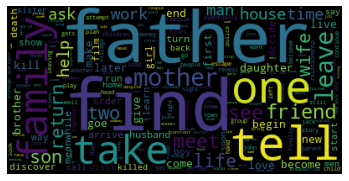

<Figure size 720x504 with 0 Axes>

In [ ]:
drama_text = movies_cleaned[movies_cleaned['genres_extract_str'].str.contains("Drama")]["plot_summary"].str.cat(sep=' ')

wordcloud = WordCloud().generate(drama_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.figure(figsize=(10,7))
plt.show()

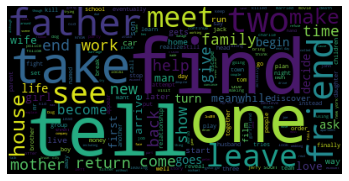

<Figure size 720x504 with 0 Axes>

In [ ]:
comedy_text = movies_cleaned[movies_cleaned['genres_extract_str'].str.contains("Comedy")]["plot_summary"].str.cat(sep=' ')

wordcloud = WordCloud().generate(comedy_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.figure(figsize=(10,7))
plt.show()

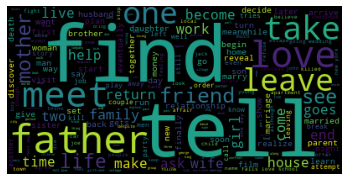

<Figure size 720x504 with 0 Axes>

In [ ]:
romance_film_text = movies_cleaned[movies_cleaned['genres_extract_str'].str.contains("Romance Film")]["plot_summary"].str.cat(sep=' ')

wordcloud = WordCloud().generate(romance_film_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.figure(figsize=(10,7))
plt.show()

In [ ]:
# all_genres = {"genre": [],
#               "num_movies": [],
#               "proportion": []}
# for key, val in genre_summary.items():
#   all_genres["genre"].append(key)
#   all_genres["num_movies"].append(val)
#   all_genres["proportion"].append(round((val / movies.shape[0]), 5))

# all_genres = pd.DataFrame(all_genres)

# all_genres = all_genres.sort_values(by = ['genre'])

In [ ]:
# all_genres[all_genres.genre.str.contains("Action")]

,genre,num_movies,proportion
5,Action,5868,0.13904
50,Action Comedy,142,0.00336
61,Action Thrillers,405,0.00960
35,Action/Adventure,3553,0.08419


## Creating Train/Test Sets

In [ ]:
movies_cleaned["genres_extract_str"] = movies_cleaned.genres_extract_short.apply(lambda x: str(x))

In [ ]:
movies_cleaned = movies_cleaned[movies_cleaned.genres_extract_str != "['']"]
movies_cleaned.reset_index(inplace=True, drop=True)

In [ ]:
### POTENTIAL BERT IMPROVEMENT
# instead of truncation from the beginning of the summaries, start from the middle / to the end
# if plot summary is greater than 100 words, sample sentences from the end
import random

def truncate_tokens(l, n=100, level="default"):
  if len(l) > n:
    if level == "default":
      out = deepcopy(l[:n])
    elif level == "reverse":
      out = deepcopy(l[-n:])
    elif level == "random":
      out = random.sample(deepcopy(l), n)
    else:
      raise Exception("Please define a word-sampling strategy.")
  else:
    out = deepcopy(l)
  return out

movies_cleaned["split_summaries"] = movies_cleaned["plot_summary"].copy().str.split()
movies_cleaned["trunc_summaries"] = movies_cleaned["split_summaries"].apply(lambda x: truncate_tokens(x, n=150, level="reverse"))
movies_cleaned["trunc_summaries"] = movies_cleaned.trunc_summaries.apply(lambda x: " ".join(x))

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movies_cleaned['genres_extract_short'].copy())
mlb.classes_

array(['Action', 'Blackandwhite', 'Comedy', 'Crime Fiction', 'Drama',
       'Horror', 'Indie', 'Other', 'Romance Film', 'Thriller',
       'World cinema'], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(movies_cleaned["plot_summary"], y, random_state=408) # plot_summary
print("train shape: {}".format(X_train.shape))
print(y_train.shape)
print("test shape: {}".format(X_test.shape))
print(y_test.shape)

train shape: (31653,)
(31653, 11)
test shape: (10551,)
(10551, 11)


# Baseline Models
Ensemble Naive Bayes model. (Initially tried KNN but KNN is invalid as a baseline comparison as it doesn't generate predictions). Constructed by running 11 individual Naive Bayes models on the top 10 genres (and one "Other"), then combining the result. <br>
Use `CountVectorizer()` and `TfidfVectorizer()` to tokenize and prepare data.

In [ ]:
### creating binarized labels for top 10 genres
movies_cleaned['is_drama'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Drama' in x).lower() == "true" else 0)
movies_cleaned['is_comedy'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Comedy' in x).lower() == "true" else 0)
movies_cleaned['is_romance_film'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Romance Film' in x).lower() == "true" else 0)
movies_cleaned['is_thriller'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Thriller' in x).lower() == "true" else 0)
movies_cleaned['is_action'] = movies_cleaned.genres_extract.apply(lambda x: 1 if (str('Action' in x).lower() == "true") or (str('Action/Adventure' in x).lower() == "true") else 0)
movies_cleaned['is_world_cinema'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('World cinema' in x).lower() == "true" else 0)
movies_cleaned['is_crime_fiction'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Crime Fiction' in x).lower() == "true" else 0)
movies_cleaned['is_horror'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Horror' in x).lower() == "true" else 0)
movies_cleaned['is_black_white'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Blackandwhite' in x).lower() == "true" else 0)
movies_cleaned['is_indie'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Indie' in x).lower() == "true" else 0)
# movies_cleaned['is_adventure'] = movies_cleaned.genres_extract.apply(lambda x: 1 if (str('Adventure' in x).lower() == "true") or (str('Action/Adventure' in x).lower() == "true") else 0)
# movies_cleaned['is_family'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Family Film' in x).lower() == "true" else 0)
# movies_cleaned['is_short'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Short Film' in x).lower() == "true" else 0)
# movies_cleaned['is_rom_drama'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Romantic drama' in x).lower() == "true" else 0)
# movies_cleaned['is_animation'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Animation' in x).lower() == "true" else 0)
# movies_cleaned['is_musical'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Musical' in x).lower() == "true" else 0)
# movies_cleaned['is_scifi'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Science Fiction' in x).lower() == "true" else 0)
# movies_cleaned['is_mystery'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Mystery' in x).lower() == "true" else 0)
# movies_cleaned['is_romcom'] = movies_cleaned.genres_extract.apply(lambda x: 1 if str('Romantic comedy' in x).lower() == "true" else 0)
movies_cleaned['is_other'] = movies_cleaned.genres_extract.apply(lambda x: 1 if len([genre for genre in x if genre not in top_10_genre_list]) >= 1 else 0)

In [ ]:
movies_cleaned.columns

Index(['wikipedia_movie_id', 'movie_name', 'plot_summary', 'genres_extract',
       'len_full_summary', 'len_cleaned_summary', 'genres_extract_short',
       'genres_extract_str', 'split_summaries', 'trunc_summaries', 'is_drama',
       'is_comedy', 'is_romance_film', 'is_thriller', 'is_action',
       'is_world_cinema', 'is_crime_fiction', 'is_horror', 'is_black_white',
       'is_indie', 'is_other'],
      dtype='object')

In [ ]:
# clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf = MultinomialNB()
targets = ['is_drama', 'is_comedy', 'is_romance_film', 'is_thriller', 'is_action', 'is_world_cinema',
           'is_crime_fiction', 'is_horror', 'is_black_white', 'is_indie', 'is_other']

def train_baseline(data=movies_cleaned, models=targets, clf=clf, verbose=False):
  """
  Helper function to create 11 separate Naive Bayes models
  and combine in ensemble to generate multi-label predictions.
  """
  df = deepcopy(data)
  genres = deepcopy(models)
  results = pd.DataFrame()

  for g in genres:
    if verbose:
      print(f"=== composing model for {g}")
    X_train, X_test, y_train, y_test = train_test_split(df['plot_summary'], df[g], random_state=408)
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])
    model.fit(X_train, y_train)
    results[g] = model.predict(X_test)

  test_true = deepcopy(df.iloc[X_test.index][targets].to_numpy())
  test_pred = deepcopy(results.to_numpy())

  return test_true, test_pred


In [ ]:
actuals, preds = train_baseline()

In [ ]:
evaluate_multi_label_f1_score(y_true=actuals, y_pred=preds)


keras Accuracy: 0.8807
Macro-F1 Score: 0.0715, Weighted F1 Score: 0.3063, Micro-F1 Score: 0.4525


## Improvements Upon Baseline

In [ ]:
### IMPROVEMENT 1: Try without Tfidf-Vectorizer (just CountVectorizer)
def improve_baseline(data=movies_cleaned, models=targets, clf=clf, verbose=False):
  df = deepcopy(data)
  genres = deepcopy(models)
  results = pd.DataFrame()

  for g in genres:
    if verbose:
      print(f"=== composing model for {g}")
    X_train, X_test, y_train, y_test = train_test_split(df['plot_summary'], df[g], random_state=408)
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', clf)
    ])
    model.fit(X_train, y_train)
    results[g] = model.predict(X_test)

  test_true = deepcopy(df.iloc[X_test.index][targets].to_numpy())
  test_pred = deepcopy(results.to_numpy())

  return test_true, test_pred

actuals_i, preds_i = improve_baseline()
evaluate_multi_label_f1_score(y_true=actuals_i, y_pred=preds_i)


keras Accuracy: 0.8402
Macro-F1 Score: 0.4893, Weighted F1 Score: 0.63, Micro-F1 Score: 0.6449


**When stopwords are removed, Improvement #1 increased all F1 scores (macro, weighted, and micro) AND keras accuracy but slightly decreased sklearn accuracy. This suggests that Tfidf-Vectorizer, which de-prioritizes high-frequency words, is detrimental and that high-frequency words actually contain more information about genres.**

In [ ]:
counter = 0
for i in range(actuals_i.shape[0]):
  if str(actuals_i[i]) == str(preds_i[i]):
    counter += 1

counter

1527

In [ ]:
results_df = pd.DataFrame(preds_i)
results_df.columns = targets.copy()
results_df.mean()

is_drama            0.580608
is_comedy           0.252867
is_romance_film     0.194579
is_thriller         0.140366
is_action           0.170316
is_world_cinema     0.134774
is_crime_fiction    0.069946
is_horror           0.075064
is_black_white      0.026443
is_indie            0.018292
is_other            0.818027
dtype: float64

## MultiGenre Baseline (Decision Trees)
https://towardsai.net/p/l/predicting-genres-from-movie-quotes

old model metrics (full plot summary) (363 genres)

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
### grabbing top 19 + 1 genres then training the dt classifier with truncated summaries

movies_cleaned["genres_extract_short"] = movies_cleaned["genres_extract"].apply(lambda x: recategorize_target(x, top_20_genre_list))
movies_cleaned.reset_index(inplace=True, drop=True)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movies_cleaned['genres_extract_short'].copy())
print(mlb.classes_)

X_train, X_test, y_train, y_test = train_test_split(movies_cleaned["trunc_summaries"], y, random_state=408) # plot_summary
print("train shape: {}".format(X_train.shape))
print(y_train.shape)
print("test shape: {}".format(X_test.shape))
print(y_test.shape)

In [ ]:
# 20+1 genres, truncated summaries

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

print("==== fitting pipeline on train data")
pipeline.fit(X_train, y_train)

print("==== generating predictions")
preds = pipeline.predict(X_test)

print("evaluating model predictions")
print("\n")
print("model results:")
evaluate_multi_label_f1_score(y_true=y_test, y_pred=preds)

In [ ]:
# training dt classifier with all genres and full cleaned summaries (with tfidf)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movies_cleaned['genres_extract'].copy())

X_train, X_test, y_train, y_test = train_test_split(movies_cleaned['plot_summary'], y, random_state=408) # plot_summary
print("train shape: {}".format(X_train.shape))
print(y_train.shape)
print("test shape: {}".format(X_test.shape))
print(y_test.shape)

train shape: (31650,)
(31650, 364)
test shape: (10550,)
(10550, 364)


In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

print("==== fitting pipeline on train data")
pipeline.fit(X_train, y_train)

print("==== generating predictions")
preds = pipeline.predict(X_test)

print("evaluating model predictions")
print("\n")
print("model results:")

==== fitting pipeline on train data
==== generating predictions
evaluating model predictions


model results:


In [ ]:
evaluate_multi_label_f1_score(y_true=y_test, y_pred=preds)


keras Accuracy: 0.9864
Macro-F1 Score: 0.0697, Weighted F1 Score: 0.2749, Micro-F1 Score: 0.2799


In [ ]:
# training dt classifier with first 300 words plot summary and all genres (with tfidf)

X_train_short = pd.DataFrame(X_train.copy())
X_test_short = pd.DataFrame(X_test.copy())
X_train_short["plot_summary"] = X_train_short.plot_summary.apply(lambda x: (" ").join(x.split()[:300]))
X_test_short["plot_summary"] = X_test_short.plot_summary.apply(lambda x: (" ").join(x.split()[:300]))

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

print("==== fitting pipeline on train data")
pipeline.fit(X_train_short["plot_summary"], y_train)

print("==== generating predictions")
preds = pipeline.predict(X_test_short["plot_summary"])

print("evaluating model predictions")
print("\n")
print("model results:")

==== fitting pipeline on train data
==== generating predictions
evaluating model predictions


model results:


In [ ]:
evaluate_multi_label_f1_score(y_true=y_test, y_pred=preds)


keras Accuracy: 0.9863
Macro-F1 Score: 0.0694, Weighted F1 Score: 0.2733, Micro-F1 Score: 0.2779


In [ ]:
# dt classifier, 363 genres, full summary, no tfidf

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movies_cleaned['genres_extract'].copy())

X_train, X_test, y_train, y_test = train_test_split(movies_cleaned['plot_summary'], y, random_state=408) # plot_summary
print("train shape: {}".format(X_train.shape))
print(y_train.shape)
print("test shape: {}".format(X_test.shape))
print(y_test.shape)

train shape: (31650,)
(31650, 364)
test shape: (10550,)
(10550, 364)


In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

print("==== fitting pipeline on train data")
pipeline.fit(X_train, y_train)

print("==== generating predictions")
preds = pipeline.predict(X_test)

print("evaluating model predictions")
print("\n")
print("model results:")

==== fitting pipeline on train data
==== generating predictions
evaluating model predictions


model results:


In [ ]:
evaluate_multi_label_f1_score(y_true=y_test, y_pred=preds)


keras Accuracy: 0.9875
Macro-F1 Score: 0.0685, Weighted F1 Score: 0.278, Micro-F1 Score: 0.2896


In [ ]:
# dt classifier, truncated 300 word summary, no tfidf
X_train_short = pd.DataFrame(X_train.copy())
X_test_short = pd.DataFrame(X_test.copy())

In [ ]:
X_train_short["plot_summary"] = X_train_short.plot_summary.apply(lambda x: (" ").join(x.split()[:300]))
X_test_short["plot_summary"] = X_test_short.plot_summary.apply(lambda x: (" ").join(x.split()[:300]))

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

print("==== fitting pipeline on train data")
pipeline.fit(X_train_short["plot_summary"], y_train)

print("==== generating predictions")
preds = pipeline.predict(X_test_short["plot_summary"])

print("evaluating model predictions")
print("\n")
print("model results:")

==== fitting pipeline on train data
==== generating predictions
evaluating model predictions


model results:


In [ ]:
evaluate_multi_label_f1_score(y_true=y_test, y_pred=preds)


keras Accuracy: 0.9875
Macro-F1 Score: 0.0681, Weighted F1 Score: 0.2724, Micro-F1 Score: 0.2847


# BERT Model
Reference resources:
*  https://github.com/datasci-w266/2022-spring-main/blob/master/materials/walkthrough_notebooks/bert-finetuning/BERT_Fine-tuning.ipynb
* https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a
* https://huggingface.co/docs/transformers/model_summary#autoencoding-models 
* https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209 

In [ ]:
# !pip install transformers

     |████████████████████████████████| 4.0 MB 9.1 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 38.0 MB/s 
     |████████████████████████████████| 895 kB 34.4 MB/s 
     |████████████████████████████████| 6.5 MB 20.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# from transformers import BertConfig, BertTokenizer, TFBertModel
from transformers import RobertaConfig, RobertaTokenizer, TFRobertaModel

In [ ]:
#######################################
### --------- Setup BERT ---------- ###

# name of the BERT model to use
model_name = "roberta-base" # 'bert-base-uncased'
# max length of tokens
max_length = 130

# load transformers config and set output_hidden_states to False; used for method 2 below
# config = RobertaConfig.from_pretrained(model_name)
# config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name) 
# Load the Transformers BERT model
bert_model = TFRobertaModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# other potential optimizer (rather than default, taken from Jensen's Medium article)
# Set an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)

def create_classification_model(max_length=max_length,
                                bert_model=bert_model,
                                train_layers = -1, 
                                optimizer=optimizer):
    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    # token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   # 'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}


    # restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    # load the Transformers BERT model as a layer in a Keras model
    pooled_output = bert_model(bert_inputs)[1] # pull pooled outputs vs. sequence outputs
    # add additional Dense layer
    # layer_1 = tf.keras.layers.Dense(units=3*len(mlb.classes_), name="add_layer_1")(bert_out)
    # batch_size = tf.shape(pooled_output)[0]
    dropout_layer = tf.keras.layers.Dropout(0.1, name='dropout')(pooled_output) # noise_shape=[batch_size, 1, max_length], 

    # build model output
    classification = tf.keras.layers.Dense(units=len(mlb.classes_), 
                                           # kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), 
                                           activation="sigmoid",
                                           name='classification_layer')(dropout_layer)
    
    # combine in model
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], # token_type_ids, not needed for RoBERTa but needed for BERT
                                          outputs=classification,
                                          name="RoBERTa_multilabel_model")

    # compile model
    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=tf.keras.metrics.BinaryAccuracy('accuracy'))

    return classification_model

In [ ]:
# testing loss function
# tf.keras.losses.BinaryCrossentropy(from_logits=False)(np.array([[1, 0, 1]]), np.array([[0.9, 0.9, 0.9]]))
# (np.log(0.9) + np.log(0.1) + np.log(0.9))/3

In [ ]:
# construct model
model = create_classification_model()
model.summary()

Model: "RoBERTa_multilabel_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 130)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                        

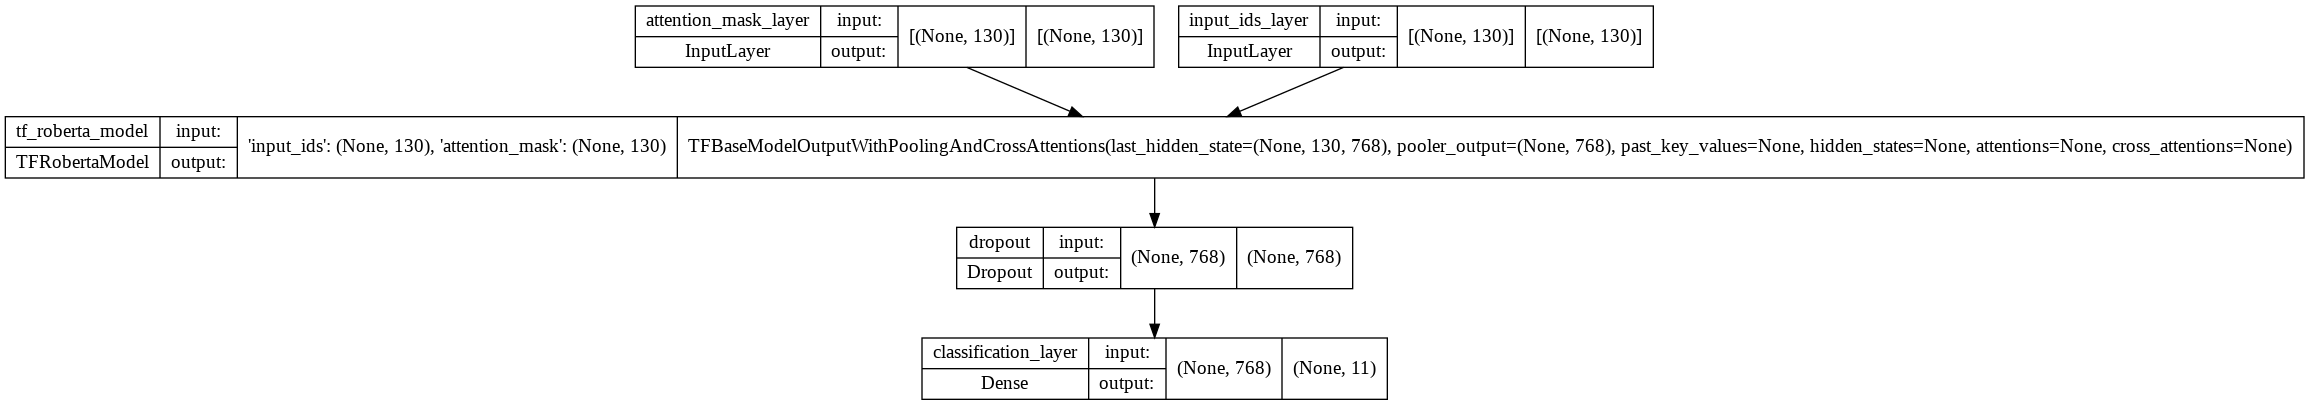

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           to_file="/content/drive/MyDrive/W266 - Natural Language Processing/roberta_model_diagram.png", 
           show_shapes=True, show_layer_names=True)

In [ ]:
# subset data for initial BERT testing; full model would take 8 hours to run without GPU
# train_limit = 200
# X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(movies_cleaned['plot_summary'][:train_limit], y[:train_limit], random_state=408)

# generate tokenized training set
X_train_tokenized = tokenizer(deepcopy(X_train).tolist(), # NOTE: replace X_train with X_sub_train when testing
                              max_length=max_length,
                              truncation=True,
                              padding='max_length',
                              return_tensors='tf')

# X_train_tokenized.input_ids.numpy()

# tokenize test dataset for prediction
X_test_tokenized = tokenizer(deepcopy(X_test).tolist(), # NOTE: replace X_test with X_sub_test when testing
                             max_length=max_length,
                             truncation=True,
                             padding='max_length',
                             return_tensors='tf')

In [ ]:
# FULL RUN (not testing on subset of data)

# set mini-batching batch size
BATCH = 70

#######################################
### ------- Train the model ------- ###
history = model.fit([X_train_tokenized.input_ids, X_train_tokenized.attention_mask],
                    y_train, 
                    validation_split=0.15,
                    epochs=5,
                    batch_size=BATCH)

Epoch 1/5
385/385 [==============================] - 730s 2s/step - loss: 0.3699 - accuracy: 0.8429 - val_loss: 0.3389 - val_accuracy: 0.8539
Epoch 2/5
385/385 [==============================] - 720s 2s/step - loss: 0.3282 - accuracy: 0.8582 - val_loss: 0.3229 - val_accuracy: 0.8596
Epoch 3/5
385/385 [==============================] - 720s 2s/step - loss: 0.3158 - accuracy: 0.8630 - val_loss: 0.3192 - val_accuracy: 0.8616
Epoch 4/5
385/385 [==============================] - 720s 2s/step - loss: 0.3082 - accuracy: 0.8665 - val_loss: 0.3182 - val_accuracy: 0.8622
Epoch 5/5
385/385 [==============================] - 720s 2s/step - loss: 0.3032 - accuracy: 0.8683 - val_loss: 0.3191 - val_accuracy: 0.8614


In [ ]:
# generate predictions
model_preds = model.predict([X_test_tokenized.input_ids, X_test_tokenized.attention_mask], # X_test_tokenized.token_type_ids, not needed for RoBERTa but needed for BERT
                            batch_size=BATCH)

In [ ]:
# inspect outputs
model_preds[0:5]
# dataset_out = pd.DataFrame(model_preds)
# dataset_out.to_csv('/content/drive/MyDrive/W266 - Natural Language Processing/bert_output_220405.csv', index=False)

array([[0.01111769, 0.22054553, 0.7808739 , 0.02230545, 0.287022  ,
        0.0214145 , 0.10503698, 0.8957521 , 0.10079486, 0.05990758,
        0.00869814],
       [0.5261923 , 0.02124549, 0.08046985, 0.05459782, 0.05157287,
        0.5372623 , 0.05900111, 0.9122457 , 0.00598239, 0.30523264,
        0.06294449],
       [0.05896101, 0.22773254, 0.5531617 , 0.2842329 , 0.25655714,
        0.00338233, 0.09581425, 0.6361333 , 0.07479997, 0.11083087,
        0.01944166],
       [0.03060449, 0.4796028 , 0.48131874, 0.00993229, 0.16432838,
        0.00164714, 0.07131526, 0.86002886, 0.36527503, 0.00569747,
        0.00719158],
       [0.00438484, 0.00527643, 0.12290736, 0.01785777, 0.7805143 ,
        0.00906865, 0.34091052, 0.7639197 , 0.08597741, 0.02126897,
        0.1061433 ]], dtype=float32)

In [ ]:
def set_threshold(num, t=0.3):
  """
  Map input number to 0 or 1 (binary) given threshold.
  """
  if num <= t:
    return 0
  else:
    return 1

def array_map(x):
  """
  Map function to array.
  """
  return np.array(list(map(set_threshold, x)))

def nested_map(pred_ndarray):
  """
  Convert np.ndarray of floats (between 0 and 1) to np.ndarray of binary integers (0 or 1)
  """
  preds = deepcopy(pred_ndarray)
  
  for i in range(len(preds)):
    preds[i] = array_map(preds[i])

  return preds

In [ ]:
#######################################
### ----- Evaluate the model ------ ###

# run evaluation
print("Bert evaluation:")
model_eval = model.evaluate(
    [X_test_tokenized.input_ids, X_test_tokenized.attention_mask], # X_test_tokenized.token_type_ids, not needed for RoBERTa but needed for BERT
    y_test # NOTE: replace y_test with y_sub_test when testing
)

print("Self evaluation")
# need to convert preds back to mlb-convertable format: convert probability into binary
bert_preds = nested_map(model_preds)
evaluate_multi_label_f1_score(y_true=y_test, y_pred=bert_preds) # NOTE: replace y_test with y_sub_test when testing

Bert evaluation:
330/330 [==============================] - 91s 277ms/step - loss: 0.3275 - accuracy: 0.8590
Self evaluation

keras Accuracy: 0.8435
Macro-F1 Score: 0.5341, Weighted F1 Score: 0.6609, Micro-F1 Score: 0.6768


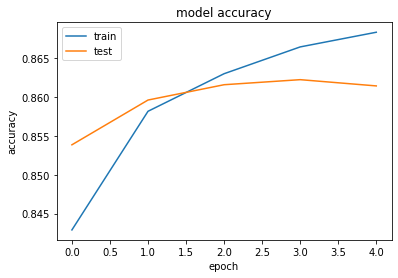

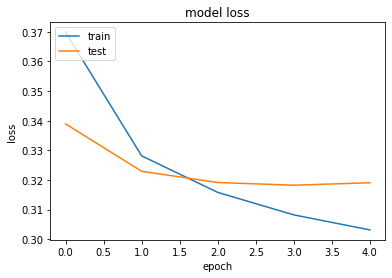

In [ ]:
# plot metrics to check for overfitting
# code borrowed from https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# test output df
test_results = pd.DataFrame({
    "summaries": X_test.copy(),
    "y_true": mlb.inverse_transform(y_test.copy()),
    "y_pred": mlb.inverse_transform(bert_preds.copy())
})
test_results.to_csv("/content/drive/MyDrive/W266 - Natural Language Processing/final_output_220405.csv", index=True)

In [ ]:
### inspect prediction results
test_results = pd.read_csv("/content/drive/MyDrive/W266 - Natural Language Processing/final_output_220405.csv")
test_results.shape

(10551, 4)

In [ ]:
test_results['is_drama'] = test_results.y_true.apply(lambda x: 1 if str('Drama' in x).lower() == "true" else 0)
test_results['is_comedy'] = test_results.y_true.apply(lambda x: 1 if str('Comedy' in x).lower() == "true" else 0)
test_results['is_romance_film'] = test_results.y_true.apply(lambda x: 1 if str('Romance Film' in x).lower() == "true" else 0)
test_results['is_thriller'] = test_results.y_true.apply(lambda x: 1 if str('Thriller' in x).lower() == "true" else 0)
test_results['is_action'] = test_results.y_true.apply(lambda x: 1 if (str('Action' in x).lower() == "true") or (str('Action/Adventure' in x).lower() == "true") else 0)
test_results['is_world_cinema'] = test_results.y_true.apply(lambda x: 1 if str('World cinema' in x).lower() == "true" else 0)
test_results['is_crime_fiction'] = test_results.y_true.apply(lambda x: 1 if str('Crime Fiction' in x).lower() == "true" else 0)
test_results['is_horror'] = test_results.y_true.apply(lambda x: 1 if str('Horror' in x).lower() == "true" else 0)
test_results['is_black_white'] = test_results.y_true.apply(lambda x: 1 if str('Blackandwhite' in x).lower() == "true" else 0)
test_results['is_indie'] = test_results.y_true.apply(lambda x: 1 if str('Indie' in x).lower() == "true" else 0)
test_results['is_other'] = test_results.y_true.apply(lambda x: 1 if str('Other' in x).lower() == "true" else 0)

In [ ]:
test_results = test_results.drop(labels=test_results.columns[test_results.columns.str.contains("is_")].tolist(), axis=1)
test_results["full_accurate"] = np.where(test_results["y_true"] == test_results["y_pred"], 1, 0)
test_results.query("full_accurate > 0")

,Unnamed: 0,summaries,y_true,y_pred,full_accurate
8,15005,evelyn killed mulwray glasses gittes confronts evelyn relationship katherine gittes slaps repeatedly cries shes sister daughter haltingly tells sexual abuse father age 15 adds eyeglasses husbands wear bifocals gittes decides help evelyn katherine escape escobar suspects evelyn mulwrays murder gittes accessory fact gittes plans two women flee mexico fisherman client curly instructs evelyn meet butlers home chinatown gittes arranges cross meet mulwrays home cross admits intends incorporate northwest valley city los angeles irrigate develop gittes produces crosss bifocals physical evidence linking mulwrays murder mulvihill appears forces surrender glasses take katherine three reach hiding place chinatown police already arrest gittes withholding evidence extortion cross approaches katherine saying grandfather evelyn brandishes small pistol cross undeterred shoots arm evelyn speeds away katherine police open fire killing evelyn cross clutches katherine takes away escobar orders gittes released along associates one urges forget jake chinatown jake associates walk away escobar directs crowd away crime scene,"('Crime Fiction', 'Drama', 'Other', 'Thriller')","('Crime Fiction', 'Drama', 'Other', 'Thriller')",1
24,7553,servais mont photographer meets nadine chevalier earns money starring cheap softcore movies trying help borrows money loan sharks finance theatrical production richard iii gives nadine part nadine torn servais falling love husband jacques moral obligations,"('Drama', 'Other', 'Romance Film')","('Drama', 'Other', 'Romance Film')",1
35,38503,entire incident secret eventually gold coin found shibus aunt uncle become extra sweet cleverly trace origin gold coin white elephant following shibu returns forest meet airawat meanwhile maharaja comes village hunting strikes tent near forest sibus uncle aunt tell maharaja existence white elephant rare spot maharaja promises handsome reward lead white elephant maharaja gives money uncle aunt sibu handed returning village aunt uncle killed wild animals jungle maharaja swears capture elephant learns sibus friendship airawat sibus uncle decides set trap next morning maharaja takes sibu forest along associates dozen elephants puts gun poor boys head calls airwat threatens surrender sibus head blown pieces airawat surrenders taken captivity maharaja sibu becomes desperate rescue airawat asks mynah summon animals forest declare war maharaja elephants tigers cobras animals unite attack maharajas camp airwat held hostage kill anybody overpower maharaja lackeys manage successfully secure airawats release free airawat goes back forest sibu followed animals,"('Drama', 'Other')","('Drama', 'Other')",1
61,28393,1840s foppish diego de la vega returns spain family california find father replaced ruler area cruel ruler luis quintero despite skilled swordsman diego downplays skills front evil captain esteban shows bit clown front family however diego secretly picks sword justice zorro fights return justice region people,"('Action', 'Other')","('Action', 'Other')",1
79,3757,film woman named jennefer runs abusive husband gives baby adoption ends streets grim cold winter toronto shes taken prostitute named ola ola sees pimp hassan murder another prostitute refuses testify knowing hassan associates kill police officer named mcclaren attempts interrogate deported jennefer becomes prostitute hassan later confronts husband tracks intent killing,"('Crime Fiction', 'Drama', 'Other', 'Thriller')","('Crime Fiction', 'Drama', 'Other', 'Thriller')",1
...,...,...,...,...,...
10528,9189,small american town town residents live peacefully small community one day trucks mysteriously start come life develop minds end prompting violence starting destroy houses kill people rest townspeople figure way destroy kill residents town,"('Horror', 'Other')","('Horror', 'Other')",1
10535,21804,story begins reporter interviewing charles templeton deathbed told eyes charles tem

In [ ]:
test_results.query("full_accurate > 0").to_csv("/content/drive/MyDrive/W266 - Natural Language Processing/perfect_results_220407.csv", index=False)

# *** ARCHIVED CODE ***
Stored for reference or potential future use

In [ ]:
# Blackstock & Spritz F1 score calculation

# def evaluate_multi_label_f1_score(y_true, y_pred, mlb=mlb):
#   """
#   Calculate the F1 score of a dataset given the true (actual/correct) labels and the predicted (guessed) labels,
#   according to the logic leveraged by Blackstock & Spritz in their 2008 paper.
#   Slightly adjusted to include accuracy, macro- and micro-F1 scores.
  
#   Takes 2 sparse matrices as input (y_true and y_pred), as well as 
#   the MultilabelBinarizer object to convert the classes, and
#   Prints an output of precision, recall, and overall F1 score.

#   Also calculates percentage of all possible labels in test set that were covered by predictions.

#   **NOTE**: Accuracy is NOT a good metric for this problem. It is heavily skewed
#   by the high cardinality of the target (there are many, many possible classes while each data sample
#   will only ever belong to a few of those classes -- never all).
#   """
#   # transform sparse matrices back to list of labels (text)
#   gold_labels = deepcopy(mlb.inverse_transform(y_true))
#   pred_labels = deepcopy(mlb.inverse_transform(y_pred))

#   # initialize counters
#   gold_counter = {}
#   correct_counter = {}
#   guess_counter = {}

#   for idx in range(len(gold_labels)):
#     # idx is an index for a tuple of actual genres
#     labels = gold_labels[idx]
#     guesses = pred_labels[idx]
#     for i in labels:
#       # i is a string, actual label
#       # increment counter to keep track of how many records should belong to this label (genre)
#       gold_counter[i] = gold_counter.get(i, 0) + 1
#       if i in guesses:
#         # increment counter to count how many correct guesses for this label (genre)
#         correct_counter[i] = correct_counter.get(i, 0) + 1
    
#     for j in guesses:
#       # increment counter to keep track of how many guesses were made for this label (genre)
#       guess_counter[j] = guess_counter.get(j, 0) + 1

#   # calculate true negatives for accuracy calculation
#   total_tn = 0
#   n = len(gold_labels)

#   for k in list(gold_counter.keys()):
#     actual_neg = n - gold_counter[k]
#     guessed_neg = n - guess_counter.get(k, 0)
#     if guessed_neg <= actual_neg:
#       total_tn += guessed_neg
#     else:
#       total_tn += actual_neg

#   # initialize final precision & recall
#   total_tp = 0
#   total_fp = 0
#   total_fn = 0
#   total_precision = 0
#   total_recall = 0
#   classwise_f1 = 0

#   for c in list(gold_counter.keys()): # for each genre
#     # calculate precision = TP / TP + FP
#     fp = max(0, guess_counter.get(c, 0) - gold_counter[c])
#     precision = (correct_counter.get(c, 0) / (correct_counter.get(c, 0) + fp) 
#                  if (correct_counter.get(c, 0) + fp) > 0 else 0)
    
#     total_tp += correct_counter.get(c, 0)
#     total_fp += fp

#     # calculate recall = TP / TP + FN
#     fn = abs(min(0, guess_counter.get(c, 0) - gold_counter[c]))
#     recall = (correct_counter.get(c, 0) / (correct_counter.get(c, 0) + fn) 
#               if (correct_counter.get(c, 0) + fn) > 0 else 0)
    
#     total_fn += fn
    
#     # calculate class-wise metrics
#     class_f1 = ((2 * precision * recall) / (precision + recall) 
#                 if (precision + recall) > 0 else 0)
#     classwise_f1 += class_f1

#     total_guesses = sum(guess_counter.values())
#     total_precision += precision * (guess_counter.get(c, 0) / total_guesses) if total_guesses > 0 else 0
#     total_recall += recall * (guess_counter.get(c, 0) / total_guesses) if total_guesses > 0 else 0

#   # calculate final evaluation metrics
#   macro_f1 = classwise_f1 / len(list(gold_counter.keys()))
#   weighted_f1 = (2 * total_precision * total_recall) / (total_precision + total_recall) if (total_precision + total_recall) > 0 else 0
#   micro_f1 = total_tp / (total_tp + (0.5 * (total_fp + total_fn))) if (total_tp + (0.5 * (total_fp + total_fn))) > 0 else 0

#   accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn) if (total_tp + total_tn + total_fp + total_fn) > 0 else 0
#   print(f"Accuracy: {round(accuracy, 4)}\n")

#   print(f"Precision: {round(total_precision, 4)}, Recall: {round(total_recall, 4)}")
#   print(f"Macro-F1 Score: {round(macro_f1, 4)}, Weighted F1 Score: {round(weighted_f1, 4)}, Micro-F1 Score: {round(micro_f1, 4)}\n")

#   # calculate overall coverage of available genres
#   coverage_counter = 0
#   foreign_counter = 0

#   for p in list(guess_counter.keys()):
#     if p in list(gold_counter.keys()):
#       coverage_counter += 1
#     else:
#       foreign_counter += 1


#   print(f"Coverage: {round(coverage_counter / len(list(gold_counter.keys())), 4)}")
#   print(f"Foreign: {round(foreign_counter / len(list(guess_counter.keys())), 4)}")


## Spacy Attempt

In [ ]:
#### prepping for spacy iteration 
# ! pip install -U spacy
# ! pip install -U layers
# ! pip install -U thinc
# ! pip install -U textacy
# ! pip install -U pip setuptools wheel
# ! pip install -U thinc 
# ! python -m spacy download en_core_web_sm
"""
AMY'S COMMENTS:
make sure to restart the kernel after installing
"""

In [ ]:
from __future__ import unicode_literals
import spacy, en_core_web_sm
import textacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

def extract_part_of_speech(text, pos="verb"):
  tokens = []
  if pos == "verb":
    pattern = [{'POS': 'VERB'}]
  elif pos == "adjective":
    pattern = [{'POS': 'ADJ'}]
    
  doc = textacy.make_spacy_doc(text, lang='en_core_web_sm')
  lists = textacy.extract.matches.token_matches(doc, pattern)
  for list in lists:
    tokens.append(list.text)
  return tokens

In [ ]:
X_train_copy = X_train.copy().reset_index(drop=True)
X_test_copy = X_test.copy().reset_index(drop=True)

In [ ]:
X_train[X_train.isnull()]

In [ ]:
# X_train_copy['verb_tokens'] = X_train_copy.apply(lambda x: extract_part_of_speech(x, pos="verb"))

In [ ]:
# X_train_copy['adj_tokens'] = X_train_copy.apply(lambda x: extract_part_of_speech(x, pos="adjective"))

In [ ]:
# X_train_copy['adj_tokens'][0]

In [ ]:
# X_test_copy['verb_tokens'] = X_test_copy.apply(lambda x: extract_part_of_speech(x, pos="verb"))
# X_test_copy['adj_tokens'] = X_test_copy.apply(lambda x: extract_part_of_speech(x, pos="adj"))

## Implementing Large Scale Multi Label Text Classification Model

Reference:
* https://keras.io/examples/nlp/multi_label_classification/

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from ast import literal_eval

import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
df = movies_cleaned[["plot_summary", "genres_extract_str"]].copy()
print(len(df))

print(sum(df["genres_extract_str"].value_counts() == 1))

print(df["genres_extract_str"].nunique())

In [ ]:
df = df.groupby("genres_extract_str").filter(lambda x: len(x) > 1)
print(len(df))

In [ ]:
def make_dataset(summaries, genres, is_train=True):
    labels = tf.ragged.constant(genres.values)
    # label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (summaries.values, genres)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
df["genres_extract"] = df["genres_extract_str"].apply(
    lambda x: literal_eval(str(x))
)

In [ ]:
df["genres_extract"].values[:5]

In [ ]:
df = df[["plot_summary", "genres_extract"]]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(movies_cleaned['plot_summary'], y, random_state=408)

train_df, test_df = train_test_split(
    df,
    stratify=df["genres_extract"].values,
    random_state=408
)

In [ ]:
terms = tf.ragged.constant(train_df["genres_extract"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

In [ ]:
train_df["plot_summary"].apply(lambda x: len(x.split(" "))).describe()

In [ ]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres_extract"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["plot_summary"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

In [ ]:
vocabulary = set()
train_df["plot_summary"].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

In [ ]:
history = shallow_mlp_model.fit(
    train_dataset, validation_data=test_dataset, epochs=epochs
)

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

In [ ]:
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

## Attempting KeyBert Keyword Extraction

Based on:
- https://www.analyticsvidhya.com/blog/2022/01/four-of-the-easiest-and-most-effective-methods-of-keyword-extraction-from-a-single-text-using-python/

In [ ]:
! pip install -U keybert

In [ ]:
! pip install -U Cython

In [ ]:
from keybert import KeyBERT

In [ ]:
kw_model = KeyBERT(model='all-mpnet-base-v2')

In [ ]:
kw_model.extract_keywords(movies_cleaned.plot_summary[0], keyphrase_ngram_range=(2, 2), 
                                     stop_words='english', highlight=False,
                                     top_n=100)[:10]

[('martian civil', 0.5593),
 ('martian societi', 0.5039),
 ('releas martian', 0.5014),
 ('suit martian', 0.4556),
 ('ancient martian', 0.4538),
 ('unreciproc ballard', 0.3876),
 ('martian spirit', 0.3842),
 ('murder ballard', 0.3606),
 ('sergeant jericho', 0.35),
 ('centuri film', 0.3402)]

In [ ]:
X_train_df = pd.DataFrame(X_train.copy())
X_test_df = pd.DataFrame(X_test.copy())

In [ ]:
X_train_df["kw_plot_summary"] = X_train_df.plot_summary.apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 2), 
                                     stop_words='english', highlight=False,
                                     top_n=10))

KeyboardInterrupt: ignored